In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import random
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)


# Automatic differentiation with pytorch

$$y = f(x) = 5x^2 + 1$$
$$\frac{\partial y}{\partial x} = 10x$$
$$\frac{\partial y}{\partial x}\Big|_{x=1} = 10$$


In [2]:
x = torch.tensor(1.0, requires_grad=True)

In [3]:
y = 5 * x ** 2 + 1

In [4]:
print("Before calling `backward`, x.grad: ", x.grad)

Before calling `backward`, x.grad:  None


In [5]:
y.backward()

In [6]:
print("After calling `backward`, x.grad: ", x.grad)


After calling `backward`, x.grad:  tensor(10.)


Another example

$$y = f(x1, x2) = 5 * x_1 ^ 2 + x_2 + 1$$

$$\frac{\partial y}{\partial x_1} = 10x_1$$
$$\frac{\partial y}{\partial x_2} = 1$$

$$\frac{\partial y}{\partial x_1}\Big|_{x_1=1, x_2=10} = 10$$
$$\frac{\partial y}{\partial x_2}\Big|_{x_1=1, x_2=10} = 1$$


In [7]:
# y = 5*x**2 + 1

x1 = torch.tensor(1.0, requires_grad=True)
x2 = torch.tensor(10.0, requires_grad=True)

In [8]:
y = 5 * x1**2 + 1 + x2

In [9]:
print("Before calling `backward`, (x1.grad, x2.grad): ", (x1.grad, x2.grad))

Before calling `backward`, (x1.grad, x2.grad):  (None, None)


In [10]:
y.backward()

In [11]:
print("After calling `backward`, (x1.grad, x2.grad): ", (x1.grad, x2.grad))

After calling `backward`, (x1.grad, x2.grad):  (tensor(10.), tensor(1.))


# Working with synthetic data

## Data

In [12]:
df = pd.read_csv("data.csv")

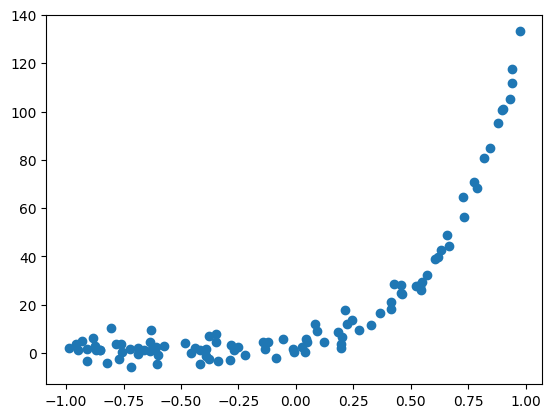

In [13]:
plt.scatter(df["x"], df["y"])

# Model

In [105]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

X = torch.tensor(df["x"])[:, None].float()
Y = torch.tensor(df["y"])[:, None].float()


model = lambda x: a + b * x
weights = [a, b]

# Loss function

In [15]:
loss_fn = lambda y_pred, y_gt: ((y_pred - y_gt) ** 2).mean()

# Optimizer

In [16]:
optimizer = torch.optim.SGD(weights, lr=1e-2)

In [17]:
def train_one_epoch(model, optimizer, X, Y, BS=100):
    indexes = np.random.permutation(len(X))
    losses = []
    a_values = []
    b_values = []
    for i, batch_start in enumerate(range(0, len(X), BS)):
        optimizer.zero_grad()

        x = X[indexes[batch_start:batch_start+BS]]
        y = Y[indexes[batch_start:batch_start+BS]]

        y_preds = model(x)

        loss = loss_fn(y_preds, y)
        loss.backward()

        optimizer.step()

        losses.append(loss.item())
        a_values.append(a.item())
        b_values.append(b.item())
        # print(f"step={i}, loss={loss.item():0.03f}, ws={[round(x.item(), 2) for x in weights]}")
    return losses, a_values, b_values

loss=386.797, a=21.939, b=40.924: 100%|██████████| 1000/1000 [00:00<00:00, 1801.47it/s]


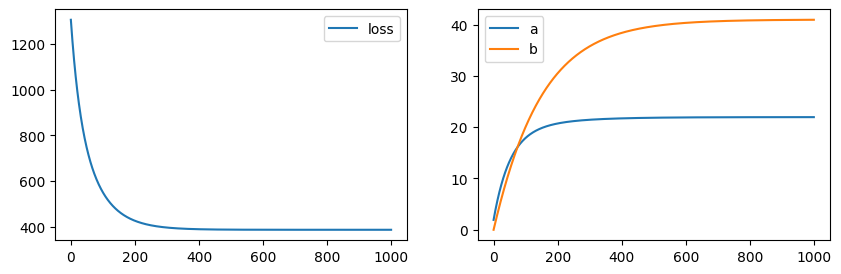

In [18]:
losses = []
a_values = []
b_values = []

pbar = tqdm(range(1000))

for ep in pbar:
    epoch_loss, epoch_a, epoch_b = train_one_epoch(model, optimizer, X, Y)
    losses.extend(epoch_loss)
    a_values.extend(epoch_a)
    b_values.extend(epoch_b)
    if (ep + 1) % 100 == 0:
        pbar.set_description(f"loss={losses[-1]:0.03f}, a={a_values[-1]:0.03f}, b={b_values[-1]:0.03f}")
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(losses, label="loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(a_values, label="a")
plt.plot(b_values, label="b")
plt.legend()


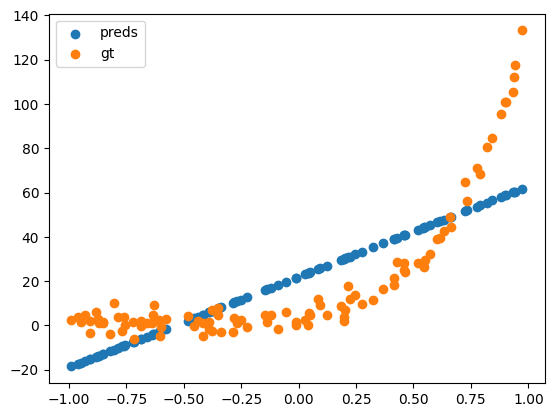

In [19]:
with torch.no_grad():
    y_preds = model(X)
    plt.scatter(X, y_preds, label="preds")
    plt.scatter(X, Y, label="gt")

plt.legend()

In [20]:
class Model(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_act="relu", n_layers=3, hidden_dim=128):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                nn.Linear(input_shape if i == 0 else hidden_dim, hidden_dim)
                for i in range(n_layers)
            ]
        )
        if hidden_act == "relu":
            self.hidden_act = nn.functional.relu
        else:
            raise ValueError

        self.output_layer = nn.Linear(hidden_dim, output_shape)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.hidden_act(x)
        output = self.output_layer(x)
        return output


In [21]:
model = Model(input_shape=1, output_shape=1)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss=39.172: 100%|██████████| 1000/1000 [00:03<00:00, 332.57it/s]


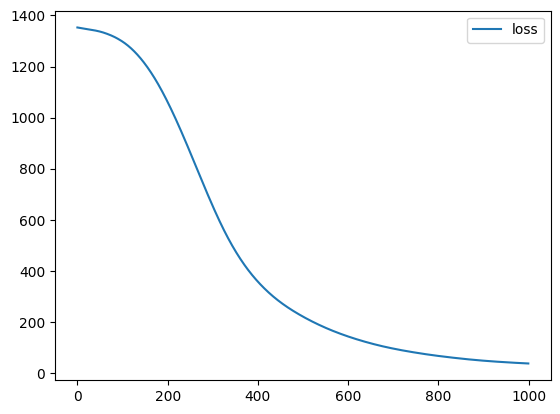

In [23]:
losses = []
a_values = []
b_values = []

pbar = tqdm(range(1000))
for ep in pbar:
    epoch_loss, epoch_a, epoch_b = train_one_epoch(model, optimizer, X[:, None], Y[:, None])
    losses.extend(epoch_loss)
    a_values.extend(epoch_a)
    b_values.extend(epoch_b)
    if (ep + 1) % 100 == 0:
        pbar.set_description(f"loss={losses[-1]:0.03f}")
plt.plot(losses, label="loss")
plt.legend()


# Exercise

You are tasked with training the following models on the given dataset.

1. $y = a + b * x $
2. $y = a + b * x + c * x^2$
3. $y = a e^{bx}$
4. a MLP. If you decide to use the `Model` class above, you must change one or more of the number of layers, the number of neurons or the activation function.

## Deliverables
* A plot with the learning curves depicting 1k epochs for each model.
* A single plot containing the predictions of the trained models and the ground truth data.
* A brief write-up explaining how the choice of the model (hypothesis function) influences the final outcome, along with suggestions for improving the results.

# 1- y=a+b∗x

In [71]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

X = torch.tensor(df["x"])[:, None].float()
Y = torch.tensor(df["y"])[:, None].float()

model = lambda x: a + b * x
weights = [a, b]

In [72]:
loss_function = lambda y_pred , y_actual : ((y_pred - y_actual) ** 2).mean()

In [73]:
optimizer = torch.optim.SGD(weights , lr=0.001)

In [74]:
def train_one_epoch(model , optimizer , X ,Y , batch_size =100):
  index = np.random.permutation(len(X))
  x_shuffled = X[index]
  y_shuffled = Y[index]

  losses = []
  a_values = []
  b_values = []


  for i in range(0 , len(X) , batch_size):
    optimizer.zero_grad()
    x = x_shuffled[i : i +batch_size]
    y = y_shuffled[i : i +batch_size]

    y_pred = model(x)
    loss = loss_function(y_pred , y)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    a_values.append(a.item())
    b_values.append(b.item())

  return losses , a_values , b_values

In [75]:
losses =[]
a_values = []
b_values = []

pbar = tqdm(range(100000))

for ep in pbar:
  epoch_loss , epoch_a , epoch_b  = train_one_epoch(model , optimizer , X ,Y , batch_size =100)
  losses.extend(epoch_loss)
  a_values.extend(epoch_a)
  b_values.extend(epoch_b)

  if (ep + 1) % 100 == 0:
     pbar.set_description(f"loss={losses[-1]:0.03f}, a={a_values[-1]:0.03f}, b={b_values[-1]:0.03f}")

loss=386.796, a=21.942, b=40.961: 100%|██████████| 100000/100000 [01:02<00:00, 1596.05it/s]


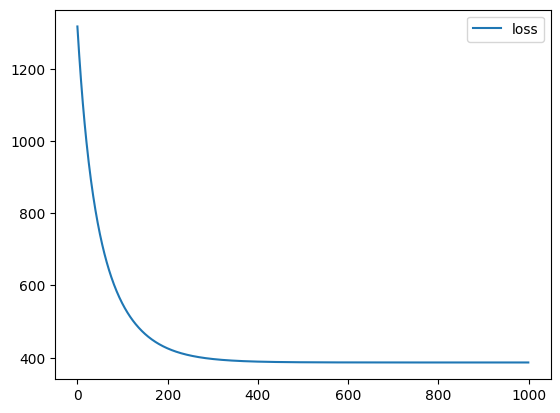

In [30]:
plt.plot(losses, label="loss")
plt.legend()

In [76]:
losses[-1]

386.79644775390625

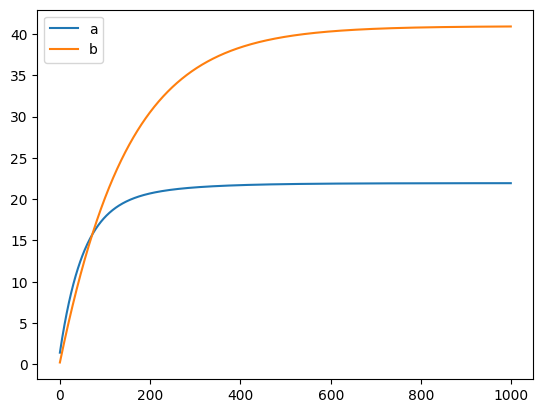

In [31]:
plt.plot(a_values, label="a")
plt.plot(b_values, label="b")
plt.legend()

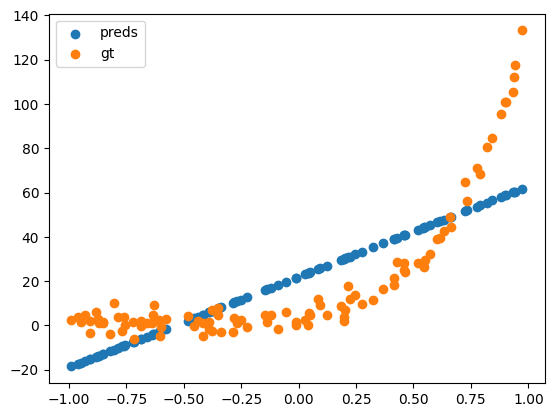

In [32]:
with torch.no_grad():
    y_preds = model(X)
    plt.scatter(X, y_preds, label="preds")
    plt.scatter(X, Y, label="gt")

plt.legend()

# 2- y=a+b∗x+c∗x2

In [39]:
a = torch.randn(1 , requires_grad = True)
b = torch.randn(1 , requires_grad = True)
c = torch.randn(1 , requires_grad = True)

X = torch.tensor(df["x"])[:, None].float()
Y = torch.tensor(df["y"])[:, None].float()

model = lambda x : a + (b * x) + c * ( x ** 2)
weights = [a , b , c]

In [47]:
loss_function = lambda y_pred , y_actual : ((y_pred - y_actual) ** 2).mean()

In [58]:
optimizer = torch.optim.SGD(weights , lr=0.001)

In [59]:
def train_one_epoch(model , optimizer , X ,Y , batch_size =100):
  index = np.random.permutation(len(X))
  x_shuffled = X[index]
  y_shuffled = Y[index]

  losses = []
  a_values = []
  b_values = []
  c_values = []

  for i in range(0 , len(X) , batch_size):
    optimizer.zero_grad()
    x = x_shuffled[i : i +batch_size]
    y = y_shuffled[i : i +batch_size]

    y_pred = model(x)
    loss = loss_function(y_pred , y)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    a_values.append(a.item())
    b_values.append(b.item())
    c_values.append(c.item())

  return losses , a_values , b_values , c_values

In [60]:
losses =[]
a_values = []
b_values = []
c_values = []

pbar = tqdm(range(100000))

for ep in pbar:
  epoch_loss , epoch_a , epoch_b , epoch_c = train_one_epoch(model , optimizer , X ,Y , batch_size =100)
  losses.extend(epoch_loss)
  a_values.extend(epoch_a)
  b_values.extend(epoch_b)
  c_values.extend(epoch_c)

  if (ep + 1) % 100 == 0:
     pbar.set_description(f"loss={losses[-1]:0.03f}, a={a_values[-1]:0.03f}, b={b_values[-1]:0.03f}")

loss=81.080, a=1.155, b=44.111: 100%|██████████| 100000/100000 [01:09<00:00, 1444.35it/s]


In [61]:
losses[-1]

81.07974243164062

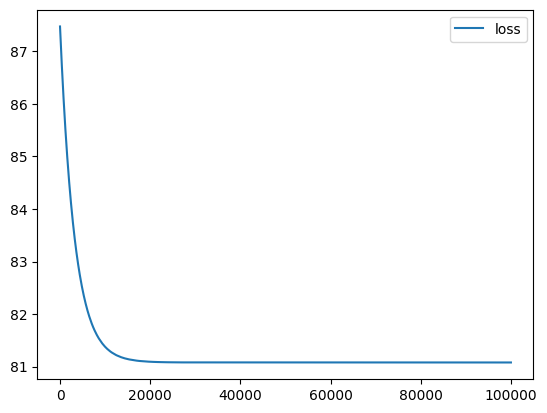

In [62]:
plt.plot(losses, label="loss")
plt.legend()

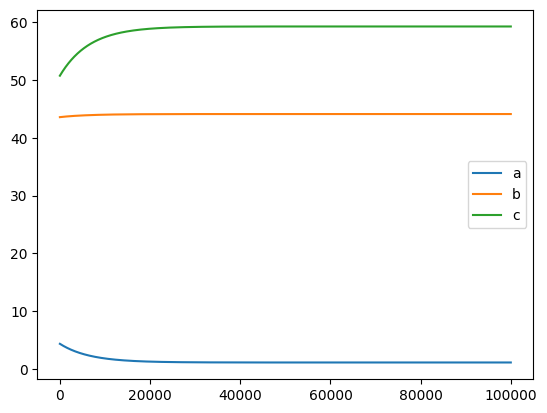

In [63]:
plt.plot(a_values, label="a")
plt.plot(b_values, label="b")
plt.plot(c_values, label="c")
plt.legend()

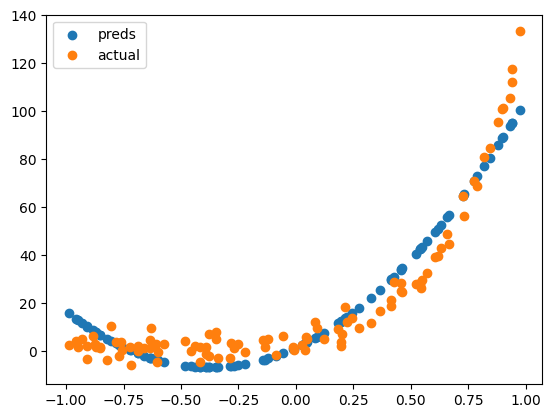

In [65]:
with torch.no_grad():
    y_preds = model(X)
    plt.scatter(X, y_preds, label="preds")
    plt.scatter(X, Y, label="actual")

plt.legend()

# 3- y=aebx

In [106]:
from math import exp
model = lambda x : a * (torch.exp(b * x))

In [107]:
optimizer = torch.optim.SGD(weights , lr=1e-6)

In [109]:
losses =[]
a_values = []
b_values = []

pbar = tqdm(range(1000000))

for ep in pbar:
  epoch_loss , epoch_a , epoch_b  = train_one_epoch(model , optimizer , X ,Y , batch_size =100)
  losses.extend(epoch_loss)
  a_values.extend(epoch_a)
  b_values.extend(epoch_b)
  c_values.extend(epoch_c)

  if (ep + 1) % 100 == 0:
     pbar.set_description(f"loss={losses[-1]:0.03f}, a={a_values[-1]:0.03f}, b={b_values[-1]:0.03f}")

loss=13.176, a=4.933, b=3.360: 100%|██████████| 1000000/1000000 [12:01<00:00, 1385.68it/s]


In [111]:
losses[-1]

13.176125526428223

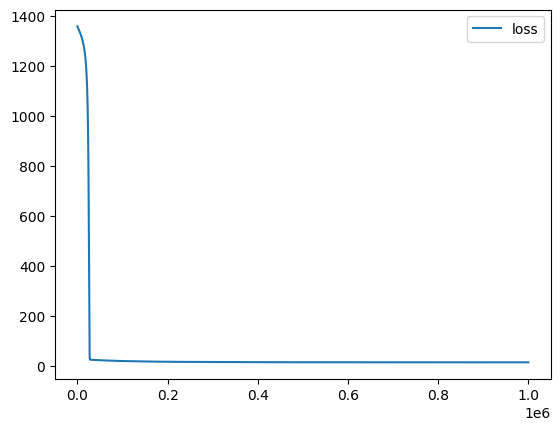

In [112]:
plt.plot(losses, label="loss")
plt.legend()

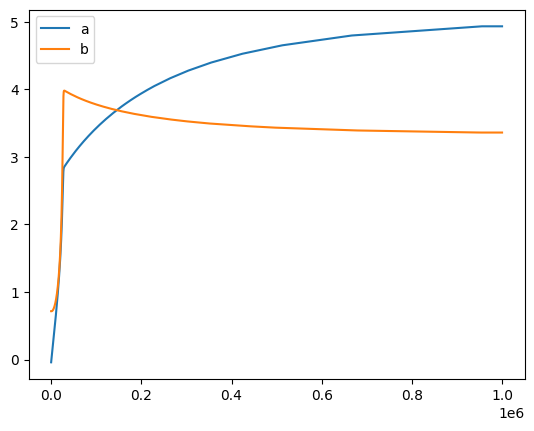

In [113]:
plt.plot(a_values, label="a")
plt.plot(b_values, label="b")
plt.legend()

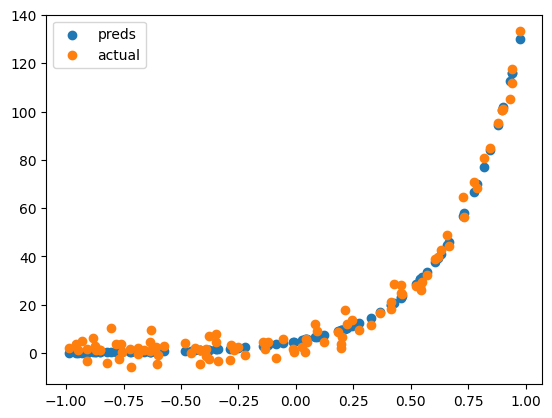

In [114]:
with torch.no_grad():
    y_preds = model(X)
    plt.scatter(X, y_preds, label="preds")
    plt.scatter(X, Y, label="actual")

plt.legend()

# Conclusion
We can see that changing the hypothesis function can cleary change the performance of the model as at the beginning the first function underfit the model resulting in huge error.
We improved that by trying to increase the degree of the function from first order to second order (polynomial regression) and we found that it fitted the model better.
Eventually we use exponential function because we knew it can also fit the model and it improved the performance of the model leading to the least amount of losses

In [115]:
class NNModel(nn.Module):
  def __init__(self , input_shape , output_shape):
    super().__init__()
    self.fc1 = nn.Linear(input_shape , 64)
    self.fc2 = nn.Linear(64 , 32)
    self.fc3 = nn.Linear(32 , 16)
    self.out = nn.Linear(16 , output_shape)

    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self , x):
    x = self.tanh(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.out(x)
    return x

In [116]:
model = NNModel(1 , 1)

In [123]:
optimizer = torch.optim.Adam(model.parameters() , lr=0.0001)

In [125]:
losses = []
a_values = []
b_values = []

pbar = tqdm(range(100000))
for ep in pbar:
    epoch_loss, epoch_a, epoch_b = train_one_epoch(model, optimizer, X[:, None], Y[:, None])
    losses.extend(epoch_loss)
    a_values.extend(epoch_a)
    b_values.extend(epoch_b)
    if (ep + 1) % 100 == 0:
        pbar.set_description(f"loss={losses[-1]:0.03f}")

loss=7.529: 100%|██████████| 100000/100000 [03:44<00:00, 444.49it/s]


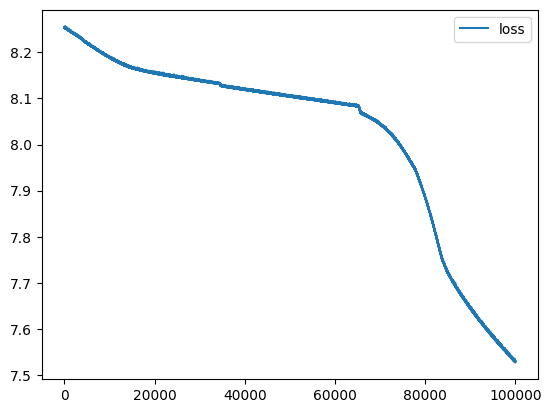

In [126]:
plt.plot(losses, label="loss")
plt.legend()

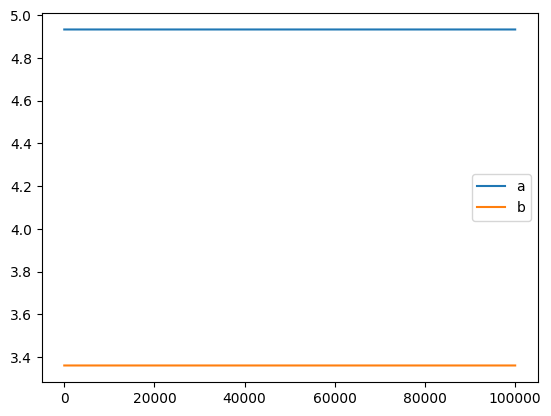

In [128]:
plt.plot(a_values, label="a")
plt.plot(b_values, label="b")
plt.legend()

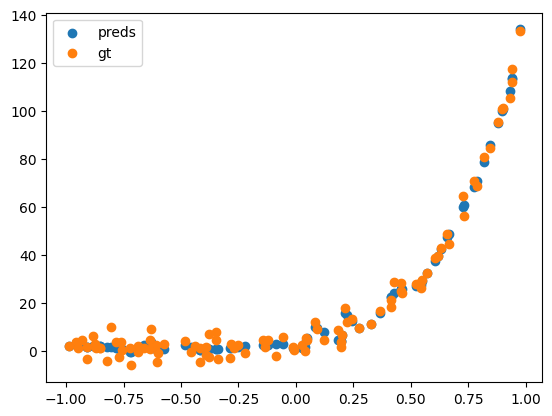

In [129]:
with torch.no_grad():
    y_preds = model(X)
    plt.scatter(X, y_preds, label="preds")
    plt.scatter(X, Y, label="gt")

plt.legend()